# Inhibitor Diffusion and Germination - Slow Release

## Numerical experiments - Week 45/2024

_Boyan Mihaylov, MSc Computational Science (UVA/VU)_

## Prerequisite libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, cuda, float32

## 1. General assumptions

Medium and conidium sizes:
- See Experiment 01.

Concentrations:
- See Experiment 01.

Membrane permeability
- The spore is assumed to have a lipid bilayer membrane with narrow channels which mediate the release of inhibitor.

## 2. Mathematical framework

The flux through the membrane is defined as

$$
J_s=-P_s\nabla c,
$$

where $P_s$ is a permeation constant depending both on the membrane and the permeating molecule. For the diffusion of glucose across an artificial lipid bilayer membrane, $P_s\approx 10^{-3}\mu\textrm{m/s}$. This is opposed to the free diffusion of molecules in a solute, which follows the flux equation

$$
J=-D\nabla c
$$

and is fundamental to Fick's law and the standard diffusion equation. This means that the formulation of the diffusion equation from Fick's law needs to be revisited with specific regard to the interface between the spore and the surrounding medium.

Consider an infinitessimal cube in a $x,y,z$-coordinate system with fluxes $J_x$, $J_y$ and $J_z$ in each dimension representing the amount of molecules passing through the cube along the respective dimension. The continuity equaition states:

$$
\frac{\partial c}{\partial t}=-\nabla J=-\frac{\partial J_x}{\partial x}-\frac{\partial J_y}{\partial y}-\frac{\partial J_z}{\partial z}
$$

Now, assume that a membrane goes through the cube and is oriented normal to one of the dimensions, e.g. $z$. Then we can replace $J_z$ by $J_s$:

$$
\frac{\partial c}{\partial t}=-\nabla J=-\frac{\partial J_x}{\partial x}-\frac{\partial J_y}{\partial y}-\frac{\partial J_s}{\partial z}
$$

Then, substituting the equation for Fick's law for $J_x=J_y=-D\nabla c$ and the modified equation $J_s=-P_s\nabla c$, we obtain

$$
\frac{\partial c}{\partial t}=D\left(\frac{\partial^2 c}{\partial x^2}+\frac{\partial^2 c}{\partial y^2}\right)+P_s\frac{\partial^2 c}{\partial z^2}.
$$

In the two-dimensional configuration, only two spatial second-order derivatives need to be considered:

$$
\frac{\partial c}{\partial t}=D\frac{\partial^2 c}{\partial x^2}+P_s\frac{\partial^2 c}{\partial y^2},
$$

where $x$ is the direction tangent to the membrane and $y$ is the direction normal to it.

### 2.1. Discretisation

Following the finite difference approximations from before, the update scheme takes the form

$$
c_{i,j}^{n+1} = D\frac{\delta{t}}{\delta{x^2}}(c_{i+1,j}^{n}+c_{i-1,j}^{n} - 2c_{i,j}^{n})+P_s\frac{\delta{t}}{\delta{x^2}}(c_{i,j+1}^{n}+c_{i,j-1}^{n}-2c_{i,j}^{n}) + c_{i,j}^{n}
$$

Depending on whether the membrane is oriented horizontally or vertically, $D$ and $P_s$ may swap in the above expression. Since in the current experiment the spore only occupies a single lattice node, it is assumed that all sides of the membrane are included in it, hence the permeation constant $P_s$ is simply used as a general factor in the update:

$$
c_{i,j}^{n+1} = \frac{P_s\delta{t}}{\delta{x^2}}(c_{i+1,j}^{n}+c_{i-1,j}^{n}+c_{i,j+1}^{n}+c_{i,j-1}^{n}-4c_{i,j}^{n}) + c_{i,j}^{n}
$$

In [63]:
def invoke_smart_kernel(size, threads_per_block=(16, 16)):
    """
    Invoke a kernel with the appropriate number of blocks and threads per block.
    """
    blocks_per_grid = [(size + (tpb - 1)) // tpb for tpb in threads_per_block]
    return tuple(blocks_per_grid), tuple(threads_per_block)


@cuda.jit()
def update_GPU(c_old, c_new, dtdx2, D, Ps, spore_idx):
    """
    Update the concentration of a lattice point based on the time-dependent diffusion equation with a periodic boundary.
    inputs:
        c_old (numpy.ndarray) - the current state of the lattice;
        c_new (numpy.ndarray) - the next state of the lattice;
        dtdx2 (float) - the update factor;
        D (float) - the diffusion constant;
        Ps (float) - the spore membrane permeation constant;
        spore_idx (tuple) - the indices of the spore location.
    """
    i, j = cuda.grid(2)

    center = c_old[i, j]
    bottom = c_old[(i - 1) % c_old.shape[0], j]
    top = c_old[(i + 1) % c_old.shape[0], j]
    left = c_old[i, (j - 1) % c_old.shape[1]]
    right = c_old[i, (j + 1) % c_old.shape[1]]
    
    Ddtdx2 = cuda.local.array(4, float32)
    for k in range(4):
        Ddtdx2[k] = D * dtdx2
    if (i, j) == spore_idx:
        for k in range(4):
            Ddtdx2[k] = Ps * dtdx2
    elif i == spore_idx[0] and j == spore_idx[1] - 1:
        Ddtdx2[0] = Ps * dtdx2
    elif i == spore_idx[0] and j == spore_idx[1] + 1:
        Ddtdx2[1] = Ps * dtdx2
    elif j == spore_idx[1] and i == spore_idx[0] - 1:
        Ddtdx2[2] = Ps * dtdx2
    elif j == spore_idx[1] and i == spore_idx[0] + 1:
        Ddtdx2[3] = Ps * dtdx2

    # c_new[i, j] = Ddtdx2 * (bottom + top + left + right - 4 * center) + center
    # c_new[i, j] = Ddtdx2A * (bottom + top - 2*center) + Ddtdx2B * (left + right - 2*center) + center
    c_new[i, j] = Ddtdx2[0]*(bottom - center) + Ddtdx2[1]*(top - center) + Ddtdx2[2]*(left - center) + Ddtdx2[3]*(right - center) + center


@cuda.reduce
def max_reduce(a, b):
    """
    Find the maximum of two values.
    """
    if a > b:
        return a
    else:
        return b


def diffusion_time_dependent_GPU(c_init, t_max, D=1.0, Ps=1.0, dt=0.001, dx=0.005, n_save_frames=100, spore_idx=(None, None), c_thresh=None):
    """
    Compute the evolution of a square lattice of concentration scalars
    based on the time-dependent diffusion equation.
    inputs:
        c_init (numpy.ndarray) - the initial state of the lattice;
        t_max (int) - a maximum number of iterations;
        D (float) - the diffusion constant; defaults to 1;
        Ps (float) - the spore membrane permeation constant; defaults to 1;
        dt (float) - timestep; defaults to 0.001;
        dx (float) - spatial increment; defaults to 0.005;
        n_save_frames (int) - determines the number of frames to save during the simulation; detaults to 100;
        spore_idx (tuple) - the indices of the spore location; defaults to (None, None);
        c_thresh (float) - a threshold value for the concentration; defaults to None.
    outputs:
        u_evolotion (numpy.ndarray) - the states of the lattice at all moments in time.
    """

    assert c_init.ndim == 2, 'input array must be 2-dimensional'
    assert c_init.shape[0] == c_init.shape[1], 'lattice must have equal size along each dimension'

    # Determine number of lattice rows/columns
    N = c_init.shape[0]

    # Save update factor
    dtdx2 =dt / (dx ** 2)

    if  D * dtdx2 > 0.5:
        print("Warning: inappropriate scaling of dx and dt due to D, may result in an unstable simulation.")

    if  Ps * dtdx2 > 0.5:
        print("Warning: inappropriate scaling of dx and dt due to Ps, may result in an unstable simulation.")

    # Determine number of frames
    n_frames = int(np.floor(t_max / dt)) + 1
    print(f"Simulation running for {n_frames} steps on a lattice of size {np.array(c_init.shape) * dx} mm.")

    # Array for storing lattice states
    c_evolution = np.zeros((n_save_frames + 1, N, N))
    times = np.zeros(n_save_frames + 1)
    save_interval = np.floor(n_frames / n_save_frames)
    save_ct = 0
    time_thresh = None

    # Initialise lattice states
    c_A_gpu = cuda.to_device(c_init)
    c_B_gpu = cuda.device_array_like(c_init)
    c_grids = [c_A_gpu, c_B_gpu]

    kernel_blocks, kernel_threads = invoke_smart_kernel(N)

    for t in range(n_frames):

        print(f"Frame {t} of {n_frames}", end="\r")
        
        update_GPU[kernel_blocks, kernel_threads](c_grids[t%2], c_grids[(t+1)%2], dtdx2, D, Ps, spore_idx)

        # Synchronize the GPU to ensure the kernel has finished
        cuda.synchronize()

        # Save time if threshold is reached
        if c_thresh is not None and time_thresh is None:
            if max_reduce(c_grids[(t+1)%2].ravel()) < c_thresh:
                time_thresh = t * dt

        # Save frame
        if t % save_interval == 0:
            c_evolution[save_ct] = c_grids[(t+1)%2].copy_to_host()
            times[save_ct] = t * dt
            save_ct += 1

    return c_evolution, times, time_thresh

### 2.2. Analytical solution

The inhibitor concentration inside the spore at time $t$ ($c_{\textrm{in}}(t)$) can be computed analytically. Since the diffusion outside the spore happens much faster than inside of it, it can be assumed that the concentration of the inhibitor outside of the spore ($c_{\textrm{out}}$) is effectively constant everywhere, i.e. equal to zero. The following formula[1] can then be used:

$$
c_{\textrm{in}}(t) = c_{\textrm{out}} - \Delta c(0)e^{-t/\tau}
$$

$\Delta c(0)$ is the difference between the external and internal concentrations at time zero. $\tau$ is a decay constant and is related to the surface area of the spore $A$, its volume $V$ and the permeability constant $P_s$:

$$
\tau=\frac{V}{AP_s}
$$

The spore area through which the inhibitor diffuses is equal to $A=4\times (5\times5)\mu\textrm{m}^2=100\mu\textrm{m}^2=0.0001\textrm{mm}^2$. The volume, as computed before, is $V=1.25\times 10^{-7}\textrm{mm}^3$

In [26]:
def permeation_time_dependent_analytical(c_in, c_out, t, Ps, A, V):
    """
    Compute the concentration of a solute in a spore given the initial and external concentrations.
    inputs:
        c_in (float) - the initial concentration of the solute;
        c_out (float) - the external concentration of the solute;
        t (float) - time;
        Ps (float) - the spore membrane permeation constant;
        A (float) - the surface area of the spore;
        V (float) - the volume of the spore.
    """
    tau = V / (A * Ps)
    c = c_out - (c_out - c_in) * np.exp(-t / tau)
    return c

## 3. Experimental setup

In [64]:
# Initialise lattice with zero concentrations
W = 4#200
H = 4#200
c_lattice = np.zeros((W+1, H+1))

# Define spore index and set concentration
c_spore_init = 1#0.9e-5
spore_idx = (W // 2, H // 2)
c_lattice[spore_idx] = c_spore_init

# # Run simulation
c_thresh = 0.1 * c_spore_init
D = 0.0006
Ps = 1e-6
t_max = 0.1#10
c_evolution, times, time_thresh = diffusion_time_dependent_GPU(c_lattice, t_max=t_max, D=D, Ps=Ps, dt=0.001, n_save_frames=100, spore_idx=spore_idx, c_thresh=c_thresh)

# Check with analytical solution
spore_vol = 1.25e-7
spore_area = 0.0001
print(f"Total concentration at final step: {np.sum(c_evolution[-1])}")
c_analytical = permeation_time_dependent_analytical(c_spore_init, 0, t_max, Ps, spore_area, spore_vol)
print(f"Numerical solution at spore for t_max={t_max}: {c_evolution[-1, spore_idx[0], spore_idx[1]]}")
print(f"Analytical solution at spore for t_max={t_max}: {c_analytical}")

Simulation running for 101 steps on a lattice of size [0.025 0.025] mm.


c:\Users\mihbo\anaconda3\Lib\site-packages\numba\cuda\dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
c:\Users\mihbo\anaconda3\Lib\site-packages\numba\cuda\dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Total concentration at final step: 8.679512851633511
Numerical solution at spore for t_max=0.1: 0.9900122364100862
Analytical solution at spore for t_max=0.1: 0.9999200031999147


## 4. Results

Concentration dropped below 0.1 at time None


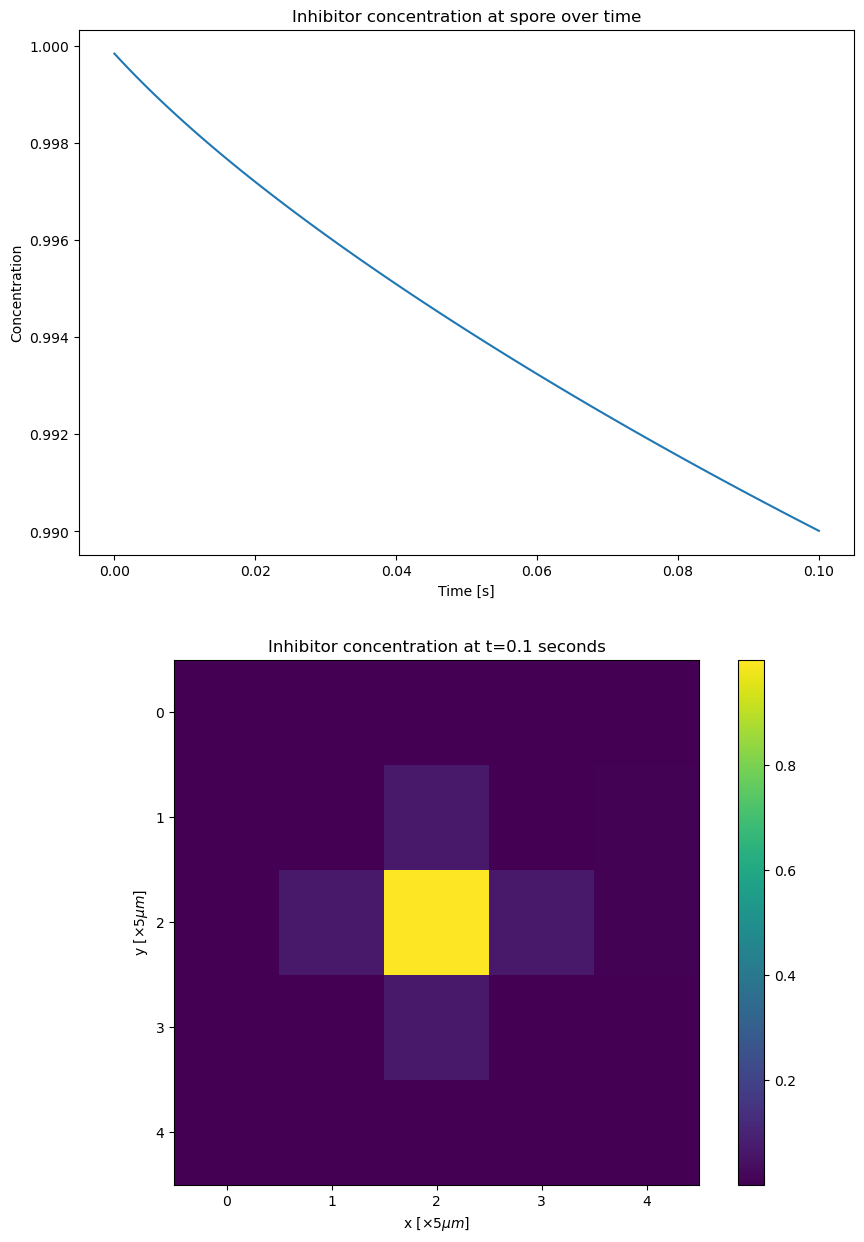

In [67]:
print(f"Concentration dropped below {c_thresh} at time {time_thresh}")

fig, axs = plt.subplots(2, 1, figsize=(10, 15))
axs[0].plot(times, c_evolution[:, spore_idx[0], spore_idx[1]])
# axs[0].axvline(x=time_thresh, color='r', linestyle='--')
axs[0].set_xlabel('Time [s]')
axs[0].set_ylabel('Concentration')
axs[0].set_title('Inhibitor concentration at spore over time')
img = axs[1].imshow(c_evolution[2], cmap='viridis')
axs[1].set_xlabel(f'x [$\\times 5\\mu m$]')
axs[1].set_ylabel(f'y [$\\times 5\\mu m$]')
axs[1].set_title(f'Inhibitor concentration at t={t_max} seconds')
fig.colorbar(img, ax=axs[1])

## References

- [1] P. C. Nelson, M. Radosavljevic, and S. Bromberg, “Biological Physics: Energy, Information, Life,” 2003.